# SAT solver using Grover's algorithm

This demo notebook shows how to use pre-coded quantum algorithm. In particular, we will use Grover's algorithm to solve a satisfiability problem, and will run the algorithm in real quantum hardware.

Grover's algorithm can be used to find in $O(\sqrt{N})$ time a solution for an unsorted search problem of $N$ elements. This can be applied, in particular, to solving the famous SAT problem, which was the first problem to be proven as **NP-hard**. Such problem accepts $2^n$ possible solutions when $n$ boolean variables are involved, and thus Grover's algorithm can reduce the $O(2^n)$ running time to $O(\sqrt{2^n}) = O(2^{n/2})$, a significant improvement.

In this notebook we will show how to solve this problem in a quantum way, for the toy case $n=3$.

## Configuration

Required imports

In [1]:
import numpy as np
from qiskit import BasicAer, QuantumCircuit, execute
from qiskit.visualization import plot_histogram
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import LogicalExpressionOracle, TruthTableOracle
from qiskit.providers.ibmq import least_busy

Now we define the particular SAT problem we will try to solve, in the standard DIMACS CNF format

In [2]:
input_3sat = '''
c example DIMACS-CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0
'''

This implements the logical expression 

$f(v_1,v_2,v_3)=(¬v_1∨¬v_2∨¬v_3)∧(v_1∨¬v_2∨v_3)∧(v_1∨v_2∨¬v_3)∧(v_1∨¬v_2∨¬v_3)∧(¬v_1∨v_2∨v_3)$

with truth table

|$v_1$|$v_2$|$v_3$|$f$|
|---|---|---|---|
|0|0|0|1|
|0|0|1|0|
|0|1|0|0|
|0|1|1|0|
|1|0|0|0|
|1|0|1|1|
|1|1|0|1|
|1|1|1|0|

so the expression is satisfiable with three possible assignments of the boolean variables.

## Circuit

Grover's algorithm requires implementing as a quantum circuit an oracle $f(x)$ that returns whether a proposed solution to the problem is valid. Fortunately, the [Qiskit Aqua library](https://github.com/Qiskit/qiskit-aqua) already provides a factory method that creates a quantum oracle function given the description of a logical expression.

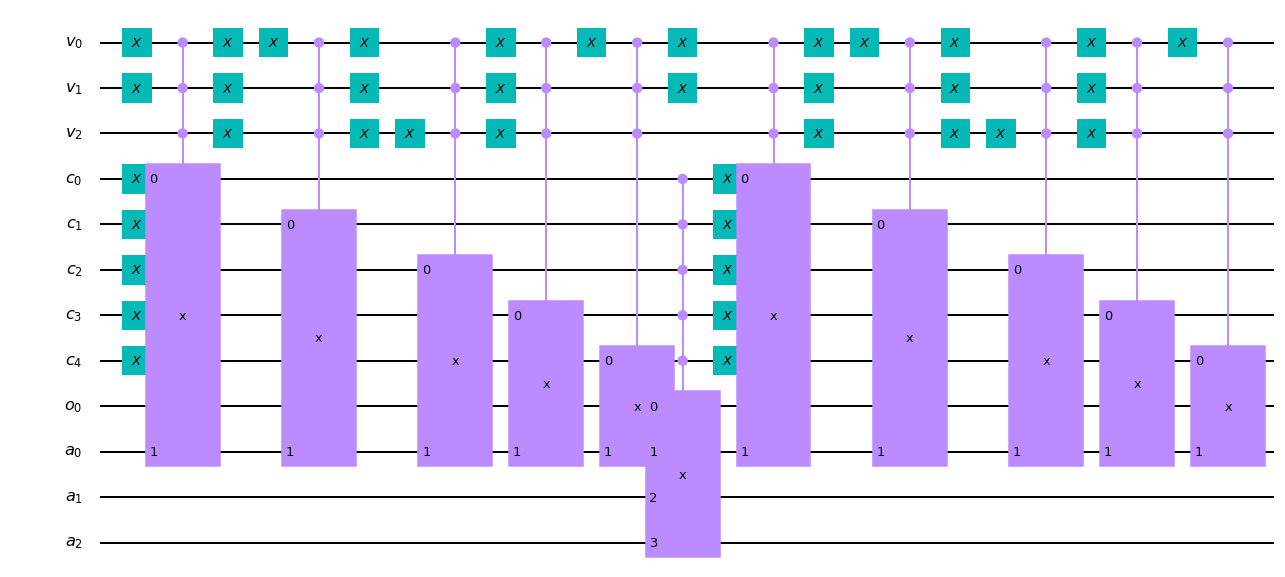

In [3]:
oracle = LogicalExpressionOracle(input_3sat)
oracle.construct_circuit().draw(output='mpl')

Now we can use this oracle as input for Grover's algorithm, also implemented in Aqua

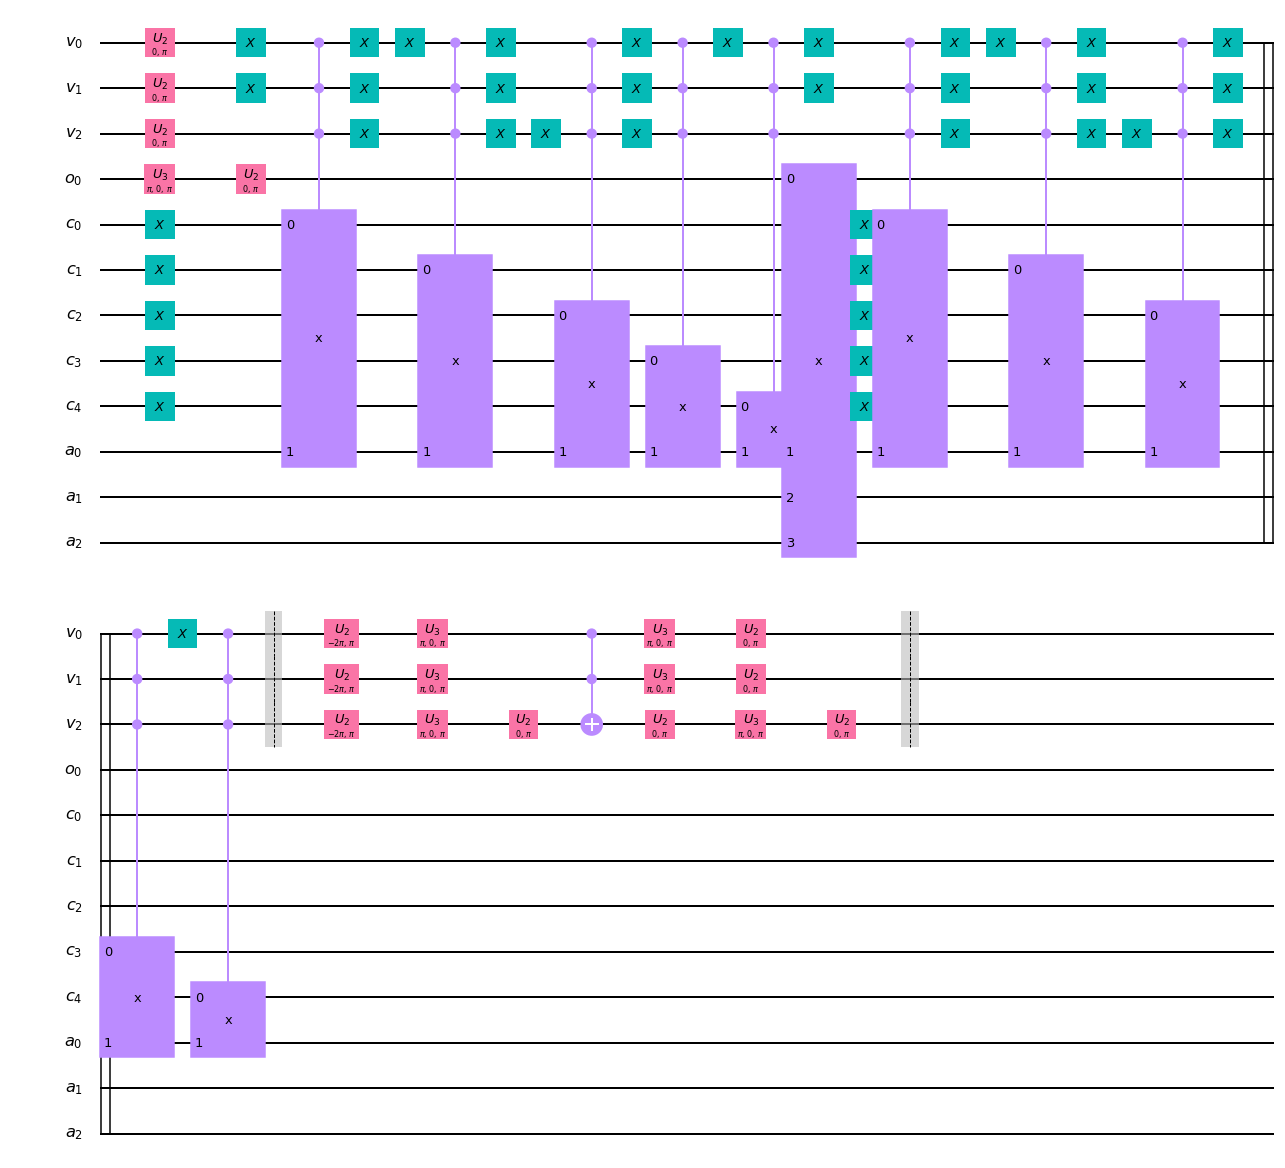

In [4]:
grover = Grover(oracle)
qc = grover.construct_circuit()
qc.draw(output='mpl')

The following functions builds the whole circuit at once

In [5]:
def nsat_solver(expression):
    oracle = LogicalExpressionOracle(expression)
    return Grover(oracle)

## Simulation

We will first run the quantum circuit in a local simulator, and check whether the results make sense. We will run 1024 shots of the QASM simulator.

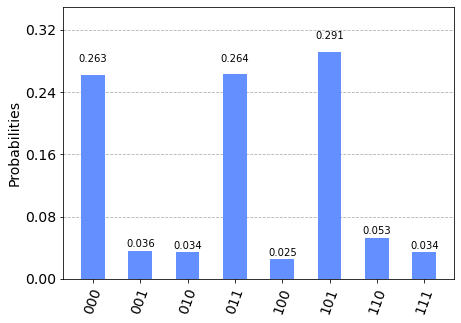

In [8]:
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
result = nsat_solver(input_3sat).run(quantum_instance)
plot_histogram(result['measurement'])

Since Grover's algorithm has a stochastic component, the solution returned is not always correct, but we can clearly see that the most probable outcomes correspond to valid assignments. It works!

## Real quantum execution

We will now go for real! We can also use qiskit to queue the execution of our quantum circuit in a real quantum simulator. First, we will check how many qubits we will need to run this particular circuit.

In [9]:
solver = nsat_solver(input_3sat)
qc = solver.construct_circuit()
nqubits = qc.num_qubits
nqubits

12

12 qubits is a large number for today's standards. We will need to look for quantum hardware able to support this number of qubits.

First we need to login into our IBMQ account. If you are running this notebook and you don't have an IBMQ account, you can find instructions [here](https://qiskit.org/documentation/install.html#access-ibm-quantum-systems) on how to create an account and configure its credentials in your computer. After that is done we can run the following to find a suitable quantum computer.

In [11]:
# Load our saved IBMQ accounts and get the ibmq_16_melbourne backend
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits and
                                   not x.configuration().simulator and x.status().operational==True))
backend

ibmqfactory.load_account:WARNING:2020-08-30 16:42:44,103: Credentials are already in use. The existing account in the session will be replaced.


<IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>

We found one! Let's now request this computer to run quantum algorith and wait for the results...

In [12]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
quantum_instance = QuantumInstance(backend, shots=1024)
result = solver.run(quantum_instance)

The skip Qobj validation does not work for IBMQ provider. Disable it.


Once the execution is finished, we can plot the results similarly to what we did with the simulator

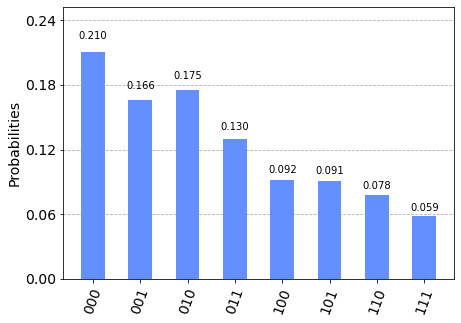

In [13]:
plot_histogram(result['measurement'])

Well it... looks a little bit off? The solution $000$ shows up with high probability, but the result of solutions do not stand out.

## Why so much noise?

The current quantum computing technology can't hold superposition states for a long time. This means circuits with a large number of gates (too deep) won't run as expected, and noise will appear in the measurements. The circuit we need to create to solve this small instance of SAT is already too deep for the extant quantum computers. We can check it out with the following

In [14]:
from qiskit.compiler import transpile

# transpile the circuit for ibmq_16_melbourne
grover_compiled = transpile(result['circuit'], backend=backend, optimization_level=3)

print('gates = ', grover_compiled.count_ops())
print('depth = ', grover_compiled.depth())

gates =  OrderedDict([('cx', 398), ('u2', 128), ('u1', 94), ('u3', 30), ('measure', 3), ('barrier', 2)])
depth =  420


These gates are too many, so with high probability quantum decoherence will ocurr, collapsing states too soon and contaminating the results of Grover's algorithm. 

Quantum hardware development is still a very active research area, and it is hoped that in the near-term future more advanced quantum computers will allow us to run this kind of algorithms effectively, surpassing classical algorithms. For the time being, we can still continue researching into new algorithms and ways to make use of the quantum computing framework.

## Closing remarks

Most of this notebook has been inspired by the ["Solving Satisfiability Problems using Grover's Algorithm" ](https://qiskit.org/textbook/ch-applications/satisfiability-grover.html) notebook in the qiskit book. Kudos also to this [Microsoft lecture on quantum computing](https://youtu.be/F_Riqjdh2oM) and the [Coursera course on introduction to quantum computing](https://www.coursera.org/learn/quantum-computing-algorithms).